This notebook script walks through each step of the ETL process with
detailed explanations, data quality checks, and visualizations to present you the thinking process.


# Load the libraries & Read the Data

In [15]:
# Import Necessary Libraries

import pandas as pd
import numpy as np
import re
import datetime
from datetime import date
import seaborn as sns 

# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------

# Define Paths 

casinodaily = r"\Users\dimitra.chatzopoulou\Desktop\demi\pesonal\CV\novibet\casino_BI_Engineer\casinodaily.csv"
casinomanufacturers = r"\Users\dimitra.chatzopoulou\Desktop\demi\pesonal\CV\novibet\casino_BI_Engineer\casinomanufacturers.csv"
casinoproviders = r"\Users\dimitra.chatzopoulou\Desktop\demi\pesonal\CV\novibet\casino_BI_Engineer\casinoproviders.csv"
currencyrates = r"\Users\dimitra.chatzopoulou\Desktop\demi\pesonal\CV\novibet\casino_BI_Engineer\currencyrates.csv"
users = r"\Users\dimitra.chatzopoulou\Desktop\demi\pesonal\CV\novibet\casino_BI_Engineer\users.csv"

# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------

# Read CSVs

df_casinodaily = pd.read_csv(casinodaily, header=0, delimiter=',')
df_casinomanufacturers = pd.read_csv(casinomanufacturers, header=0, delimiter=',')
df_casinoproviders = pd.read_csv(casinoproviders, header=0, delimiter=',')
df_currencyrates = pd.read_csv(currencyrates, header=0, delimiter=',')
df_users = pd.read_csv(users, header=0, delimiter=',')


Print the dimensionality and first rows of each dataframe to familiarize with the data 

In [16]:
print(df_casinodaily.shape)
df_casinodaily.head()

(65790, 9)


,UserID,CountryId,CurrencyId,Date,CasinoGameId,CasinoProviderId,CasinoManufacturerId,GGR,Returns
0,bo0Ykz7Nn7,106,15,2025-03-10,149671,110,101,32.411080,17.330133
1,1LbgZSf9Pz,106,15,2025-03-10,1192,21,2,70.529403,20.141626
2,icpWDuiljz,106,15,2025-03-10,17450,150,42,1.022822,1.716777
3,cJKkhthQ67,106,15,2025-03-10,15893,110,61,-25.228250,1035.080020
4,bs1jduSrAT,106,15,2025-03-10,166141,21,133,6.115386,16.613069


In [17]:
print(df_casinomanufacturers.shape)
df_casinomanufacturers.head()

(319, 1)


CasinoManufacturerId,"CasinoManufacturerName","FromDate","ToDate","LatestFlag"
1 Viaden          2019-11-15 09:11:32.287 NaN                                                                    1.0                             
2 MicroGaming     2019-11-15 09:11:32.287 2024-04-16 06:11:35.627                                                0.0                             
  Micro Gaming    2024-04-16 06:11:35.627 NaN                                                                    1.0                             
3 Evolution       2020-06-16 09:41:29.923 NaN                                                                    1.0                             
4 ScientificGames 2019-11-15 09:11:32.287 2024-04-11 06:51:11.840                                                0.0

In [18]:
print(df_casinoproviders.shape)
df_casinoproviders.head()

(38, 2)


,CasinoProviderId,CasinoProviderName
0,15,Viaden
1,21,MicroGaming
2,21,GamesGlobal
3,30,Evolution
4,40,ScientificGames


In [19]:
print(df_currencyrates.shape)
df_currencyrates.head()

(147, 5)


,Date,FromCurrencyId,ToCurrencyId,ToCurrencySysname,EuroRate
0,2025-01-03,2,15,NZD,0.544484
1,2025-01-02,2,15,NZD,0.543419
2,2025-01-01,2,15,NZD,0.539607
3,2025-01-06,2,15,NZD,0.544840
4,2025-01-05,2,15,NZD,0.544484


In [20]:
print(df_users.shape)
df_users.head()

(7734, 7)


,UserID,user_id,BirthDate,Sex,VIPStatus,Country,CountryID
0,5762754,vFFv24LBfv,1989-05-02,F,Potential,NZD,106
1,5778624,uoqSXzqFy1,1991-10-04,F,NOT vip,NZD,106
2,5610434,3lZ5PE5f7F,1994-09-06,F,NOT vip,NZD,106
3,4523919,JPikNnu1o7,1991-10-11,M,Bronz E,NZD,106
4,4564697,pIrSKY0nZu,1991-03-06,M,Bronz E,NZD,106


Fix the df_casinomanufacturers which presents quality issues.
Here we detect 6 null values in the column LatestFlag, however in the csv file we don't have any missing value in this column. So, after exploring the rows that presented missing values we understood that the csv file in the rows 19, 72, 73, 145, 271 had " " which confused pandas while reading the file. 
So, we will fix this issue

In [21]:

# Set the column names
col_names = ["CasinoManufacturerId",
    "CasinoManufacturerName", 
    "FromDate",
    "ToDate",
    "LatestFlag"]

# Read the CSV
df_casinomanufacturers = pd.read_csv(
    casinomanufacturers,
    skiprows=1,       # skip the bad header row
    header=None,      # so pandas doesn’t try to interpret row 0 as column names
    names=col_names)  # assign these exact five names


# Saniy check 
print(df_casinomanufacturers.shape)
df_casinomanufacturers.head()


# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------

# LatestFlag should not have null values 
null_mask = df_casinomanufacturers['LatestFlag'].isnull() 
if null_mask.sum() > 0:
    print(f"\nRows with null LatestFlag:")
    print(df_casinomanufacturers[null_mask])
    
df_casinomanufacturers = df_casinomanufacturers.replace('"', '', regex=True) # Remove all double quotes from the entire df

# Fix each problematic row
for idx in df_casinomanufacturers[null_mask].index:
    checkdata = str(df_casinomanufacturers.loc[idx, 'CasinoManufacturerId'])
    print(f"\nFixing row {idx}: {checkdata}")
    parts = checkdata.split(',')
    if len(parts) >= 5:
        df_casinomanufacturers.loc[idx, 'CasinoManufacturerId'] = parts[0].strip()
        df_casinomanufacturers.loc[idx, 'CasinoManufacturerName'] = parts[1].strip()
        df_casinomanufacturers.loc[idx, 'FromDate'] = parts[2].strip()
        df_casinomanufacturers.loc[idx, 'ToDate'] = parts[3].strip() if parts[3].strip() else None
        df_casinomanufacturers.loc[idx, 'LatestFlag'] = parts[4].strip()
        

(319, 5)

Rows with null LatestFlag:
                                  CasinoManufacturerId CasinoManufacturerName  \
19           15,"1X2Gaming",2019-11-15 09:11:32.287,,1                    NaN   
72   60,"4ThePlayer",2019-12-10 13:38:30.033,2025-0...                    NaN   
73         60,"4The Player",2025-02-18 15:20:14.957,,1                    NaN   
145        117,"2By2Gaming",2022-08-25 12:15:36.583,,1                    NaN   
271  217,"7777_Gaming",2024-04-17 13:57:17.367,2024...                    NaN   
272        217,"7777Gaming",2024-06-04 07:33:22.147,,1                    NaN   

    FromDate ToDate  LatestFlag  
19       NaN    NaN         NaN  
72       NaN    NaN         NaN  
73       NaN    NaN         NaN  
145      NaN    NaN         NaN  
271      NaN    NaN         NaN  
272      NaN    NaN         NaN  

Fixing row 19: 15,1X2Gaming,2019-11-15 09:11:32.287,,1

Fixing row 72: 60,4ThePlayer,2019-12-10 13:38:30.033,2025-02-18 15:20:14.957,0

Fixing row 73: 60,4T

# Data Cleaning Per dataframe

1. Drop duplicates
2. Check the data types and missing values of each column
3. Ensure you always use the latest manufacturer record (in df_casinomanufacturers)
4. Convert Data Types and fill NAs
5. Perform age calculation 
6. Create AgeGroup Column
7. Apply currency conversion for GGR (convert the GGR and Returns from NZD to EUR) 

In [22]:
# df_casinodaily
df_casinodaily.drop_duplicates(inplace=True) # no duplicates were detected for this dataframe
print(df_casinodaily.dtypes)
print(pd.DataFrame({'sum_missing': df_casinodaily.isnull().sum()}))
df_casinodaily['Date'] = pd.to_datetime(df_casinodaily['Date'])


UserID                   object
CountryId                 int64
CurrencyId                int64
Date                     object
CasinoGameId              int64
CasinoProviderId          int64
CasinoManufacturerId      int64
GGR                     float64
Returns                 float64
dtype: object
                      sum_missing
UserID                          0
CountryId                       0
CurrencyId                      0
Date                            0
CasinoGameId                    0
CasinoProviderId                0
CasinoManufacturerId            0
GGR                             0
Returns                         0


df_casinomanufacturers!
Fill the missing values of the column "ToDate" with "Present" since we can make the assumption that the reason why this column is null is because this casino manufacturer continues to to cooperate. 

CasinoManufacturerId      object
CasinoManufacturerName    object
FromDate                  object
ToDate                    object
LatestFlag                object
dtype: object
                        sum_missing_before_keeping_last
CasinoManufacturerId                                  0
CasinoManufacturerName                                0
FromDate                                              0
ToDate                                              229
LatestFlag                                            0
                        sum_missing_after_keeping_last
CasinoManufacturerId                                 0
CasinoManufacturerName                               0
FromDate                                             0
ToDate                                               0
LatestFlag                                           0


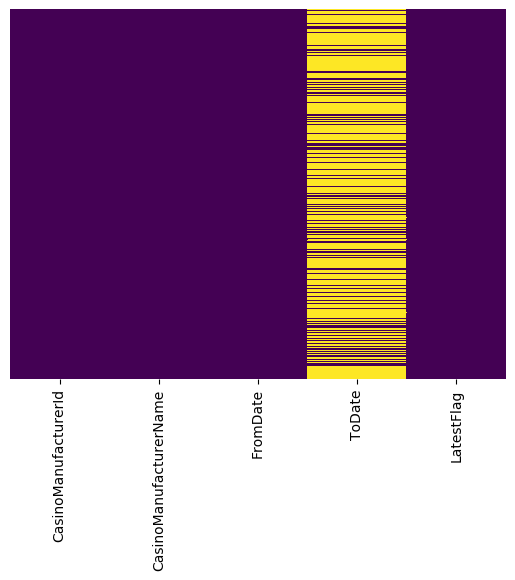

In [23]:
# df_casinomanufacturers

df_casinomanufacturers.drop_duplicates(inplace=True) # no duplicates were detected for this dataframe
print(df_casinomanufacturers.dtypes) # Check data types

# the column ToDate contains 231 null values & the column LatestFlag contains 6 null values
print(pd.DataFrame({'sum_missing_before_keeping_last': df_casinomanufacturers.isnull().sum()}))
sns.heatmap(df_casinomanufacturers.isnull(), yticklabels=False, cbar=False, cmap='viridis')

# Convert data types after fixing
df_casinomanufacturers['CasinoManufacturerId'] = pd.to_numeric(df_casinomanufacturers['CasinoManufacturerId'], errors='coerce')
df_casinomanufacturers['LatestFlag'] = pd.to_numeric(df_casinomanufacturers['LatestFlag'], errors='coerce')
df_casinomanufacturers['FromDate'] = pd.to_datetime(df_casinomanufacturers['FromDate'])
df_casinomanufacturers['ToDate'] = pd.to_datetime(df_casinomanufacturers['ToDate'])

# Ensure you always use the latest manufacturer record
df_casinomanufacturers = df_casinomanufacturers[df_casinomanufacturers['LatestFlag'] == 1].reset_index(drop=True)

# Fill nas of ToDate Column with "Present"
df_casinomanufacturers['ToDate'] = df_casinomanufacturers['ToDate'].fillna('Present')

# Check for missing values again
print(pd.DataFrame({'sum_missing_after_keeping_last': df_casinomanufacturers.isnull().sum()}))


In [24]:
# df_casinoproviders

df_casinoproviders.drop_duplicates(inplace=True) # no duplicates were detected for this dataframe# Check for missing values
print(df_casinoproviders.dtypes)
pd.DataFrame({'sum_missing': df_casinoproviders.isnull().sum()})


CasinoProviderId       int64
CasinoProviderName    object
dtype: object


,sum_missing
CasinoProviderId,0
CasinoProviderName,0


In [25]:
#  df_currencyrates

df_currencyrates.drop_duplicates(inplace=True) # no duplicates were detected for this dataframe# Check for missing values
print(df_currencyrates.dtypes)
pd.DataFrame({'sum_missing': df_currencyrates.isnull().sum()})
df_currencyrates['Date'] = pd.to_datetime(df_currencyrates['Date'])

df = pd.merge(
    df_casinodaily,
    df_currencyrates,
    left_on=['Date', 'CurrencyId'],
    right_on=['Date', 'ToCurrencyId'],
    how='left')

# Convert non-EUR currencies to EUR where rates  or keep the original one which is in EUR

#   The df dataframe will present the correct Returns & GGR based on EUR. When the transaction is in another 
#   currency it will make the conversion and replace the original values. In the cases where Returns & GGR are
#   already in EUR it will stay same 

df['GGR'] = np.where(
    df['EuroRate'].notna(),  
    df['GGR'] * df['EuroRate'],  # convert to EUR
    df['GGR']  # Keep original (assuming its EUR)
)

df['Returns'] = np.where(
    df['EuroRate'].notna(),
    df['Returns'] * df['EuroRate'],
    df['Returns']
)
# Drop unecessary columns
df.drop(columns=['FromCurrencyId', 'ToCurrencyId', 'ToCurrencySysname',], inplace=True, errors='ignore')

Date                  object
FromCurrencyId         int64
ToCurrencyId           int64
ToCurrencySysname     object
EuroRate             float64
dtype: object


In [26]:
df

,UserID,CountryId,CurrencyId,Date,CasinoGameId,CasinoProviderId,CasinoManufacturerId,GGR,Returns,EuroRate
0,bo0Ykz7Nn7,106,15,2025-03-10,149671,110,101,17.133307,9.161142,0.528625
1,1LbgZSf9Pz,106,15,2025-03-10,1192,21,2,37.283606,10.647367,0.528625
2,icpWDuiljz,106,15,2025-03-10,17450,150,42,0.540689,0.907531,0.528625
3,cJKkhthQ67,106,15,2025-03-10,15893,110,61,-13.336284,547.169176,0.528625
4,bs1jduSrAT,106,15,2025-03-10,166141,21,133,3.232746,8.782083,0.528625
...,...,...,...,...,...,...,...,...,...,...
65785,bzUyq,199,10,2025-03-31,159828,150,42,0.820806,2391.221376,NaN
65786,45GGJ,199,10,2025-04-04,157690,120,7,0.477588,1.202229,NaN
65787,X2Hqd,199,10,2025-04-19,11128,120,7,0.281606,2.255437,NaN
65788,4YTTg,199,10,2025-04-19,11153,120,7,0.331330,2.662155,NaN


In [27]:
# df_users

df_users.drop_duplicates(inplace=True) # no duplicates were detected for this dataframe# Check for missing values
print(df_users.dtypes)
pd.DataFrame({'sum_missing': df_users.isnull().sum()})
df_users['BirthDate'] = pd.to_datetime(df_users['BirthDate'], errors='coerce')

# Calculate age
today = date.today()
df_users['Age'] = (pd.Timestamp(today) - df_users['BirthDate']).dt.days // 365

# Calculate Age Group 
age_bins = [0, 18, 26, 32, 40, 50, 150]
age_labels = ['Under 18', '21-26', '27-32', '33-40', '41-50', '50+']

def assign_age_group(age):
    if age < 18:
        return 'Under 18'
    elif age >= 21 and age <= 26:
        return '21-26'
    elif age >= 27 and age <= 32:
        return '27-32'
    elif age >= 33 and age <= 40:
        return '33-40'
    elif age >= 41 and age <= 50:
        return '41-50'
    elif age > 50:
        return '50+'
    else:
        return 'Other'  # for ages 18-20
    
df_users['AgeGroup'] = df_users['Age'].apply(assign_age_group)

UserID        int64
user_id      object
BirthDate    object
Sex          object
VIPStatus    object
Country      object
CountryID     int64
dtype: object


# Aggregate the metrics 

All the preprocessed datasets are now combined into a single dataframe with the columns that was asked for.

In [28]:
df_merged = df.merge(
    df_users[['user_id', 'Country', 'Sex', 'AgeGroup', 'VIPStatus']],
    how='left',
    left_on='UserID',
    right_on='user_id')
df_merged = df_merged.drop(columns='user_id')


df_merged = df_merged.merge(
        df_casinomanufacturers[['CasinoManufacturerId', 'CasinoManufacturerName']], 
        on='CasinoManufacturerId', 
        how='left')

df_merged = df_merged.merge(
        df_casinoproviders[['CasinoProviderId', 'CasinoProviderName']], 
        on='CasinoProviderId', 
        how='left')

# -----------------------------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------------------------

final_df = df_merged[["Date", "Country", "Sex", "AgeGroup", "VIPStatus", 
                     "CasinoManufacturerName", "CasinoProviderName","GGR","Returns"]]

final_df

,Date,Country,Sex,AgeGroup,VIPStatus,CasinoManufacturerName,CasinoProviderName,GGR,Returns
0,2025-03-10,NZD,M,27-32,Bronz E,Hacksaw,Nyx,17.133307,9.161142
1,2025-03-10,NZD,M,27-32,Bronz E,Hacksaw,LightAndWonder,17.133307,9.161142
2,2025-03-10,NZD,F,33-40,POTENTIAL,Micro Gaming,MicroGaming,37.283606,10.647367
3,2025-03-10,NZD,F,33-40,POTENTIAL,Micro Gaming,GamesGlobal,37.283606,10.647367
4,2025-03-10,NZD,F,41-50,POTENTIAL,PragmaticPlay,PragmaticPlay,0.540689,0.907531
...,...,...,...,...,...,...,...,...,...
84169,2025-03-31,NaN,NaN,NaN,NaN,PragmaticPlay,PragmaticPlay,0.820806,2391.221376
84170,2025-04-04,NaN,NaN,NaN,NaN,PlayNGo,PlayNGo,0.477588,1.202229
84171,2025-04-19,NaN,NaN,NaN,NaN,PlayNGo,PlayNGo,0.281606,2.255437
84172,2025-04-19,NaN,NaN,NaN,NaN,PlayNGo,PlayNGo,0.331330,2.662155
